In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import sys
import pandas as pd
pd.set_option('display.max_columns', None)
sys.path.append("/home/dzeiberg/")
from mave_results.utils.threshold_utils import get_score_threshold, prior_from_weights

In [2]:
# Load SpliceAI
spliceAI = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/spliceai_scores.raw.snv.hg19.BRCA1.Findlay2018.tsv", sep='\t')
spliceAI = spliceAI.assign(spliceAI_score=spliceAI.SpliceAI.apply(lambda s: max(list(map(float,s.split("|")[2:6])))))
tups_spliceVariants = set(spliceAI.loc[spliceAI.spliceAI_score > .5,
                                        ['CHROM','POS','REF','ALT']].apply(tuple, axis=1).values)
# Load gnomAD r2.1.1 genomes and exomes (subset to Findlay coordinate range)
gnomad_genomes = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/gnomad.genomes.r2.1.1.sites.17.brca1.finday2018.tsv", sep='\t')
gnomad_exomes = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/gnomad.exomes.r2.1.1.sites.17.brca1.finday2018.tsv", sep='\t')
# chromosomal coordinates of gnomAD
tups_gnomad_exomes = set(gnomad_exomes.loc[:,['CHROM','POS','REF','ALT']].apply(tuple, axis=1).values)
tups_gnomad_genomes = set(gnomad_genomes.loc[:,['CHROM','POS','REF','ALT']].apply(tuple, axis=1).values)
# Load Findlay scoreset
findlay = pd.read_csv('/data/dzeiberg/IGVF-cvfg-pillar-project/pillar_data_combined_df.csv')
findlay = findlay[(findlay.Dataset == "BRCA1_Findlay_2018")].rename(columns={'hg19_pos' : "POS"})
# Assign gnomAD membership
findlay = findlay.assign(in_gnomad_exomes=findlay.loc[:,['Chrom','POS','ref_allele','alt_allele']].apply(tuple, axis=1).isin(tups_gnomad_exomes))
findlay = findlay.assign(in_gnomad_genomes=findlay.loc[:,['Chrom','POS','ref_allele','alt_allele']].apply(tuple, axis=1).isin(tups_gnomad_genomes))

def label_variant(r, annotate_splice=True, missense_only=True):
    if r.consequence == "Synonymous" or (isinstance(r.hgvs_p,str) and r.hgvs_p[-1] == "="):
        return ['synonymous']
    vcf = (r.Chrom, int(r.POS), r.ref_allele, r.alt_allele)
    if annotate_splice and vcf in tups_spliceVariants:
        return ['splicing']
    if r.consequence == "Nonsense":
        return ['nonsense']
    labels = []
    if r.CLNSIG in {'Pathogenic', 'Likely_pathogenic', "Pathogenic/Likely_pathogenic"} and (not missense_only or \
                                                                                                (missense_only and r.consequence == "Missense")):
        labels.append("P/LP")
    if r.CLNSIG in {'Benign', 'Likely_benign', "Benign/Likely_benign"} and (not missense_only or \
                                                                                                (missense_only and r.consequence == "Missense")):
        labels.append("B/LB")
    if r.in_gnomad_exomes or r.in_gnomad_genomes:
        labels.append("gnomAD")
    return labels

def makeScoreset(clinvar,**kwargs):
    clinvar = clinvar[~clinvar.CLNREVSTAT.isin({'no_assertion_provided',
                                                'no_assertion_criteria_provided'})]
    findlay_clinvar = pd.merge(findlay,
                                    clinvar,
                                    left_on=['Chrom','POS','ref_allele','alt_allele'],
                                    right_on=['CHROM','POS','REF','ALT'],
                                    how='left',
                                    validate='one_to_one')
    findlay_clinvar = findlay_clinvar.assign(labels=findlay_clinvar.apply(lambda row: label_variant(row, **kwargs), axis=1))
    return findlay_clinvar

clinvar_2018 = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/clinvar_20180505.brca1.Findlay2018.tsv", sep='\t')
clinvar_2024 = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/clinvar_20240917.brca1.Findlay2018.tsv", sep='\t')

findlay_clinvar_2018_wSplice_missense = makeScoreset(clinvar_2018,
                                            annotate_splice=False,
                                            missense_only=True)
findlay_clinvar_2018_wSplice_any = makeScoreset(clinvar_2018,
                                                annotate_splice=False,
                                                missense_only=False)
findlay_clinvar_2018_woSplice_missense = makeScoreset(clinvar_2018,
                                                annotate_splice=True,
                                                missense_only=True)
findlay_clinvar_2018_woSplice_any = makeScoreset(clinvar_2018,
                                                annotate_splice=True,
                                                missense_only=False)


findlay_clinvar_2024_wSplice_missense = makeScoreset(clinvar_2024,
                                            annotate_splice=False,
                                            missense_only=True)
findlay_clinvar_2024_wSplice_any = makeScoreset(clinvar_2024,
                                                annotate_splice=False,
                                                missense_only=False)
findlay_clinvar_2024_woSplice_missense = makeScoreset(clinvar_2024,
                                                annotate_splice=True,
                                                missense_only=True)
findlay_clinvar_2024_woSplice_any = makeScoreset(clinvar_2024,
                                                annotate_splice=True,
                                                missense_only=False)

/tmp/ipykernel_3641888/3147703990.py:7: DtypeWarning: Columns (566,570,571) have mixed types. Specify dtype option on import or set low_memory=False.
  gnomad_genomes = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/gnomad.genomes.r2.1.1.sites.17.brca1.finday2018.tsv", sep='\t')
/tmp/ipykernel_3641888/3147703990.py:8: DtypeWarning: Columns (328) have mixed types. Specify dtype option on import or set low_memory=False.
  gnomad_exomes = pd.read_csv("/data/dzeiberg/IGVF-cvfg-pillar-project/Pillar_project_data_files/vcf/gnomad.exomes.r2.1.1.sites.17.brca1.finday2018.tsv", sep='\t')
/tmp/ipykernel_3641888/3147703990.py:13: DtypeWarning: Columns (3,6,7,8,9,10,11,12,13,14,15,16,17,19,20) have mixed types. Specify dtype option on import or set low_memory=False.
  findlay = pd.read_csv('/data/dzeiberg/IGVF-cvfg-pillar-project/pillar_data_combined_df.csv')


In [5]:
findlay_clinvar_2018_wSplice_any.to_json("/data/dzeiberg/circularity/Findlay2018_wSplice_any.json")
findlay_clinvar_2018_woSplice_any.to_json("/data/dzeiberg/circularity/Findlay2018_woSplice_any.json")
findlay_clinvar_2018_wSplice_missense.to_json("/data/dzeiberg/circularity/Findlay2018_wSplice_missense.json")
findlay_clinvar_2018_woSplice_missense.to_json("/data/dzeiberg/circularity/Findlay2018_woSplice_missense.json")

findlay_clinvar_2024_wSplice_any.to_json("/data/dzeiberg/circularity/Findlay2024_wSplice_any.json")
findlay_clinvar_2024_woSplice_any.to_json("/data/dzeiberg/circularity/Findlay2024_woSplice_any.json")
findlay_clinvar_2024_wSplice_missense.to_json("/data/dzeiberg/circularity/Findlay2024_wSplice_missense.json")
findlay_clinvar_2024_woSplice_missense.to_json("/data/dzeiberg/circularity/Findlay2024_woSplice_missense.json")

In [22]:
counts = {}
for name,df in [[("2018",'with_splice','missense'), findlay_clinvar_2018_wSplice_missense],
                [("2018",'with_splice','any'), findlay_clinvar_2018_wSplice_any],
                [("2018",'without_splice','missense'), findlay_clinvar_2018_woSplice_missense],
                [("2018",'without_splice','any'), findlay_clinvar_2018_woSplice_any],
                [("2024",'with_splice','missense'), findlay_clinvar_2024_wSplice_missense],
                [("2024",'with_splice','any'), findlay_clinvar_2024_wSplice_any],
                [("2024",'without_splice','missense'), findlay_clinvar_2024_woSplice_missense],
                [("2024",'without_splice','any'), findlay_clinvar_2024_woSplice_any]]:
    counts[name] = {"P/LP" : df[df.labels.apply(lambda x: "P/LP" in x)].shape[0],
                    "B/LB" : df[df.labels.apply(lambda x: "B/LB" in x)].shape[0],
                    "gnomAD" : df[df.labels.apply(lambda x: "gnomAD" in x)].shape[0],
                    "synonymous" : df[df.labels.apply(lambda x: "synonymous" in x)].shape[0]}

In [23]:
pd.DataFrame.from_dict(counts,orient='index')

P/LP  B/LB  gnomAD  synonymous
2018 with_splice    missense    75    18     249         544
                    any        182    87     249         544
     without_splice missense    63    17     226         544
                    any         64    86     226         544
2024 with_splice    missense   177    77     249         544
                    any        315   256     249         544
     without_splice missense   157    76     226         544
                    any        159   255     226         544

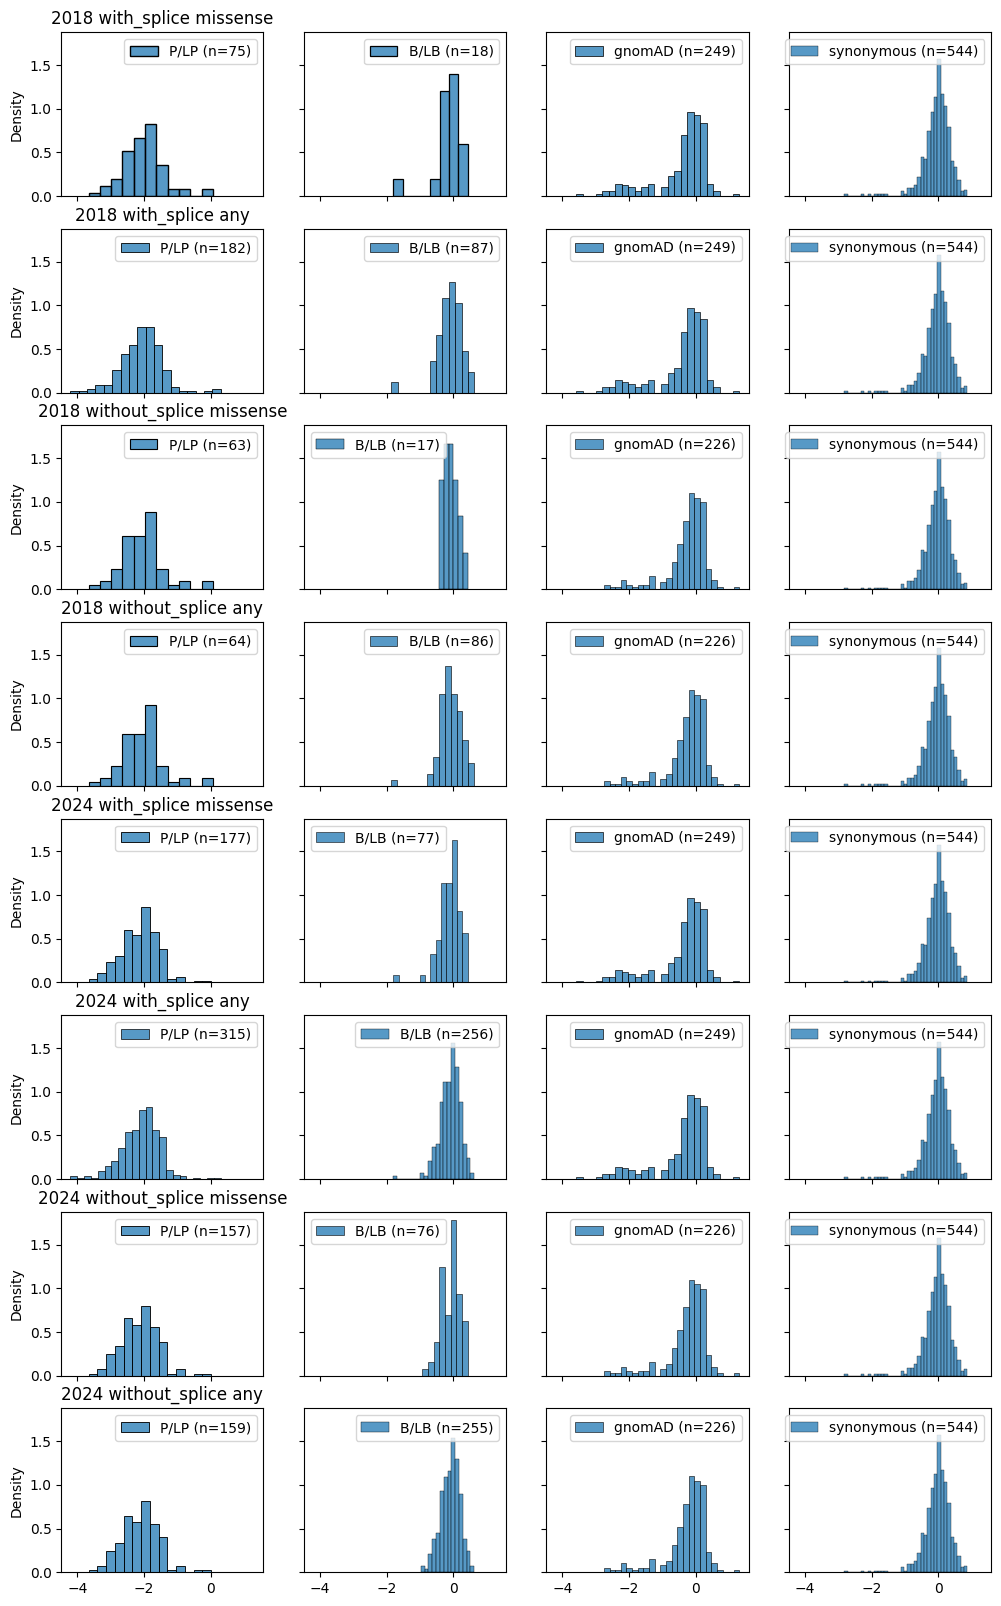

In [ ]:
fig, axs = plt.subplots(8,4,figsize=(12,20),sharey=True,sharex=True)

for i,(name,df) in enumerate([[("2018",'with_splice','missense'), findlay_clinvar_2018_wSplice_missense],
                [("2018",'with_splice','any'), findlay_clinvar_2018_wSplice_any],
                [("2018",'without_splice','missense'), findlay_clinvar_2018_woSplice_missense],
                [("2018",'without_splice','any'), findlay_clinvar_2018_woSplice_any],
                [("2024",'with_splice','missense'), findlay_clinvar_2024_wSplice_missense],
                [("2024",'with_splice','any'), findlay_clinvar_2024_wSplice_any],
                [("2024",'without_splice','missense'), findlay_clinvar_2024_woSplice_missense],
                [("2024",'without_splice','any'), findlay_clinvar_2024_woSplice_any]]):
    p = df.loc[df.labels.apply(lambda li: "P/LP" in li),'auth_reported_score'].values
    b = df.loc[df.labels.apply(lambda li: "B/LB" in li),'auth_reported_score'].values
    g = df.loc[df.labels.apply(lambda li: "gnomAD" in li),'auth_reported_score'].values
    s = df.loc[df.labels.apply(lambda li: "synonymous" in li),'auth_reported_score'].values
    ax = axs[i]
    sns.histplot(p, stat='density',ax=ax[0],label='P/LP (n={})'.format(len(p)))
    sns.histplot(b, stat='density',ax=ax[1],label='B/LB (n={})'.format(len(b)))
    sns.histplot(g, stat='density',ax=ax[2],label='gnomAD (n={})'.format(len(g)))
    sns.histplot(s, stat='density',ax=ax[3],label='synonymous (n={})'.format(len(s)))
    [ax[j].legend() for j in range(4)]
    ax[0].set_title(" ".join(name))



In [ ]:
from tqdm.autonotebook import trange
from random import shuffle
def runFitIter(observations, sample_indicators, **kwargs):
    try:
        iter_fit = main.single_fit(observations,sample_indicators,**kwargs)
        return iter_fit, iter_fit['likelihoods'][-1]
    except AssertionError:
        iter_fit = dict(component_params=None, weights=None, likelihoods=[-1 * np.inf])
        return iter_fit, -1 * np.inf

def prepSampleIndicators(df):
    sample_indicators = np.zeros((df.shape[0],3))
    sampleNames = {"P/LP", "B/LB", "gnomAD", "synonymous"}
    map = {"P/LP" : 0, "B/LB" : 1, "gnomAD" : 2, "synonymous" : 3}
    for i in range(df.shape[0]):
        intersection = set(df.labels.iloc[i]).intersection(sampleNames)
        if len(intersection) == 0:
            continue
        if 'synonymous' in intersection:
            sample_indicators[i,2] = 1
            continue
        intersection = list(labels)
        shuffle(intersection)
        sample_indicators[i,map[intersection[0]]] = 1
    return sample_indicators

def runFits(df,NFITS = 10,
                NBootstraps=100):
    observations = df.auth_reported_score.values
    sample_indicators = prepSampleIndicators(df)
    missing = sample_indicators.sum(axis=1) == 0
    observations = observations[~missing]
    sample_indicators = sample_indicators[~missing]
    fits = []
    for iteration in trange(NFITS):
        bootstrap_sample_indices = [np.random.choice(np.where(sample_i)[0],
                                                         sample_i.sum(),
                                                         replace=True) for sample_i in sample_indicators.T]
        indices = np.concatenate(bootstrap_sample_indices)
        XB = observations[indices]
        SB = sample_indicators[indices]
        fit_results = Parallel(n_jobs=min(128,NBootstraps),verbose=10)(delayed(runFitIter)(XB,SB) \
                                                                            for i in range(NBootstraps))
        fit_results = sorted(fit_results,key=lambda tup: tup[1],reverse=True)
        fits.append(fit_results[0][0])
    return fits

/tmp/ipykernel_3631373/3986631819.py:1: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import trange


In [ ]:
clinvar18_results = runFits

In [7]:
clinvar18_results = []
clinvar24_results = []
for result_file in results_rt.glob("*BRCA1_Findlay_2018.json"):
    with result_file.open() as f:
        r = json.load(f)
    r['weights'] = np.array(r['weights'])
    clinvar18_results.append(r)
for result_file in results_rt.glob("*BRCA1_Findlay_2024.json"):
    with result_file.open() as f:
        r = json.load(f)
    r['weights'] = np.array(r['weights'])
    clinvar24_results.append(r)

In [8]:
len(clinvar18_results), len(clinvar24_results)

(1008, 1008)

In [9]:
rng = np.arange(max([min(r['observations']) for r in [*clinvar18_results, *clinvar24_results]]),
                min([max(r['observations']) for r in [*clinvar18_results, *clinvar24_results]]),
                .01)

In [10]:
# Pscores, Bscores, priors,is_inverted, P, B,log_lrPlus, number_invalid_priors = get_score_threshold...

metrics2018 = get_score_threshold(rng, clinvar18_results,point_values=[1,2,4,8])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   24.0s


apply prior requirement


[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:   34.5s finished


In [11]:
metrics2024 = get_score_threshold(rng, clinvar24_results,point_values=[1,2,4,8])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 128 concurrent workers.
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 544 tasks      | elapsed:   15.4s


apply prior requirement


[Parallel(n_jobs=-1)]: Done 1008 out of 1008 | elapsed:   25.4s finished


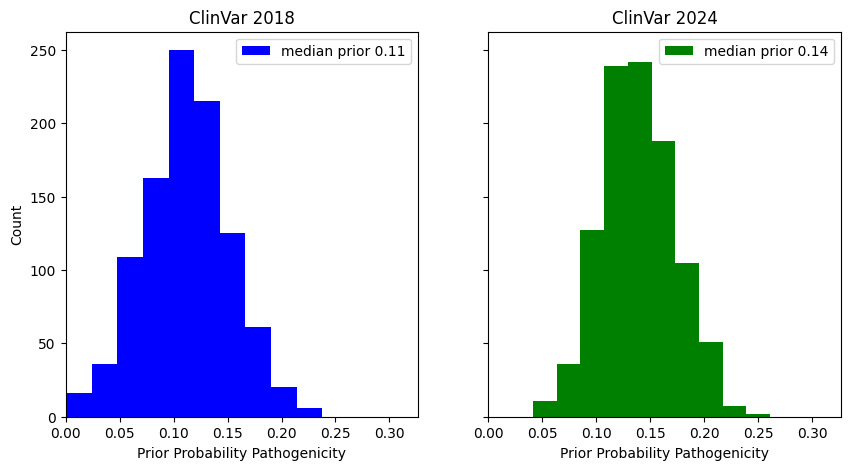

In [12]:
fig,ax = plt.subplots(1,2,figsize=(10,5),sharex=True, sharey=True)
ax[0].hist(metrics2018[2],color='blue',
            label=f"median prior {np.nanmedian(metrics2018[2]):.2f}")
ax[0].set_title("ClinVar 2018")
ax[1].hist(metrics2024[2],color='green',
            label=f"median prior {np.nanmedian(metrics2024[2]):.2f}")
ax[1].set_title("ClinVar 2024")
[axi.set_xlabel("Prior Probability Pathogenicity") for axi in ax]
ax[0].set_ylabel("Count")
ax[0].set_xlim(0,max(metrics2024[2]) * 1.25)
[axi.legend() for axi in ax]

(-5.76448657672453, 6.772476278296093)

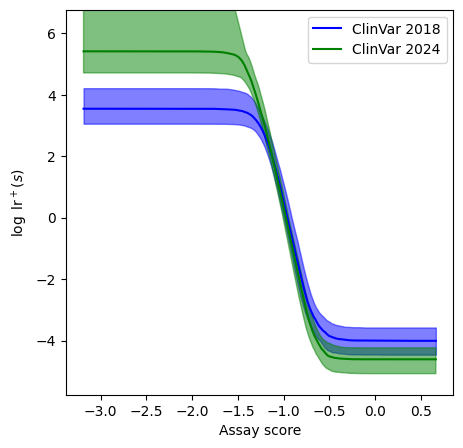

In [13]:
fig, ax = plt.subplots(1,1,figsize=(5,5))
median2018 = np.median(metrics2018[6],axis=0)
ax.plot(rng,median2018,label="ClinVar 2018",color='blue')
ax.fill_between(rng,*np.quantile(metrics2018[6],axis=0,q=[.25,.75]),color='blue',alpha=.5)
median2024 = np.median(metrics2024[6],axis=0)
ax.plot(rng,median2024,label="ClinVar 2024",color='green')
ax.fill_between(rng,*np.quantile(metrics2024[6],axis=0,q=[.25,.75]),color='green',alpha=.5)
ax.legend()
ax.set_xlabel("Assay score")
ax.set_ylabel(r"$\log \text{ lr}^+(s)$")
ax.set_ylim(min(median2018.min(),median2024.min()) * 1.25,
            max(median2018.max(),median2024.max()) * 1.25)

In [14]:
np.stack((metrics2018[0],metrics2018[1]))

array([[-1.12651908, -1.18651908,         nan,         nan],
       [-0.77651908, -0.71651908, -0.53651908,         nan]])

In [15]:
np.stack((metrics2024[0],metrics2024[1]))

array([[-1.10651908, -1.15651908, -1.26651908,         nan],
       [-0.83651908, -0.79001908, -0.67651908,         nan]])

In [ ]:
np.isnan(metrics2018[4]).sum(0) / len(metrics2018[4])

In [ ]:
np.isnan(metrics2024[4]).sum(0) / len(metrics2024[4])

In [ ]:
np.stack([r['weights'] for r in clinvar18_results]).mean(0)

In [ ]:
np.stack([r['component_params'][0] for r in clinvar18_results]).mean(0)

In [ ]:
np.stack([r['component_params'][1] for r in clinvar18_results]).mean(0)